In [ ]:
'''
Investiages the correlation between frequency and severity of violations
through per user analyses

1. Find frequency and severity for each user
    - freq = (# hours of violation) / (total # hours recorded)
    - sevr = sum of (required temperature - measured temperature) / (total # hours recorded)
                for all violations
2. Plot each user as a datapoint and perform regression
3. Conclude
'''

import csv
import sys
import os
from datetime import datetime

In [ ]:
def calculate_sevr(time, measured_temp, outside_temp):
    '''
    Calculates (required temperature - measured temperature),
    taking into account the time to adjust required temp.
    Returns 0 if measured_temp is not a violation
    :type time: datetime
    :type measured_temp: int
    :type outside_temp: int (optional for nighttime)
    '''
    measured_temp = int(measured_temp)
    try:
        outside_temp = int(outside_temp)
    except Exception:
        outside_temp = None
    diff = 0
    day = [hr for hr in range(6, 22)] # day: 6 AM - 10 PM
    night = [22, 23, 0, 1, 2, 3, 4, 5] # night: 10 PM - 6 AM
    if time.hour in day:
        if not outside_temp:
            # Daytime calculation requires outside_temp, but csv files sometimes don't
            # satisfy this condition so treating not-enough-info as just non-violationf or now
            pass
            # raise ValueError('Daytime calculation requires outside_temp information')
        elif outside_temp < 55:
            required_temp = 68
            diff = required_temp - measured_temp
        else:
            # Not a violation
            pass
        
    if time.hour in night:
        required_temp = 62
        diff = required_temp - measured_temp
    
    # Turning non-violating diff's into 0 
    if diff < 0:
        diff = 0
        
    return diff
        

In [ ]:
class Row:
    def __init__(self, user_id, sensor_id, temp, created_at, outdoor_temp, violation):
        self.user_id = user_id
        self.sensor_id = sensor_id
        self.temp = temp
        self.created_at = created_at
        self.outdoor_temp = outdoor_temp
        self.violation = violation
        
    def __repr__(self):
        return f'<Row Object> user_id: {self.user_id}'
    
    def __str__(self):
        return __repr__(self)
    
    def __eq__(self, another_row):
        '''
        Two Row objects are equal if they have the same user_id
        '''
        return self.user_id == another_row.user_id
    

In [ ]:
class User:
    def __init__(self, row):
        self.user_id = row.user_id
        self.row_list = [row]
        self.num_violation = 0
        if row.violation:
            self.num_violation += 1
        
    def add_row(self, row):
        if self.user_id != row.user_id:
            raise ValueError('This row does not belong to this user')
        self.row_list.append(row)
        if row.violation:
            self.num_violation += 1
        
    def __repr__(self):
        return f'<User Object> user_id: {self.user_id}'
    
    def __str__(self):
        return __repr__(self)
    
    def freq(self):
        '''
        Calculates the frequency of violation for this user
        freq = (# hours of violation) / (total # hours recorded)
        '''
        return self.num_violation / len(self.row_list)
    
    def sevr(self):
        '''
        Calculates the severity of violation for this user
        sevr = sum of (required temp - measured temp) / (total # hours recorded)
        '''
        severity = 0
        for row in self.row_list:
            severity += calculate_sevr(row.created_at, row.temp, row.outdoor_temp)
        severity /= len(self.row_list)
        return severity
        

In [ ]:
def import_file(path):
    '''
    Imports dataset in a standardized manner
    '''
    
    users = []

    with open(path, 'r', newline='') as f:
        csv_reader = csv.reader(f)
        next(csv_reader)
        for row in csv_reader:
            row[0] = int(row[0])
            row[2] = int(row[2])
            row[3] = datetime.strptime(row[3], "%Y-%m-%d %H:%M:%S")
            row[4] = row[4]
            if row[5] == 'true':
                row[5] = True
            elif row[5] == 'false':
                row[5] = False
            else:
                raise ValueError('unexpected value for violation')
            row = Row(*row)
            user_found = False
            for user in users:
                if row.user_id == user.user_id:
                    user.add_row(row)
                    user_found = True
            if not user_found:
                users.append(User(row))
    return users

In [ ]:
def compute_freq_sevr(users):
    '''
    Returns datapoints in the format (freq, sevr) for each user in users
    '''
    datapoints = []
    for user in users:
        freq = user.freq()
        sevr = user.sevr()
        datapoint = (freq, sevr)
        datapoints.append(datapoint)
    return datapoints

In [ ]:
users = import_file('./data/dataset/clean_013118_053118.csv')
datapoints = compute_freq_sevr(users)
datapoints

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1098.
Date:                Thu, 15 Nov 2018   Prob (F-statistic):           9.47e-33
Time:                        20:16:33   Log-Likelihood:                 41.796
No. Observations:                  45   AIC:                            -81.59
Df Residuals:                      44   BIC:                            -79.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.0001      0.121     33.131      0.0

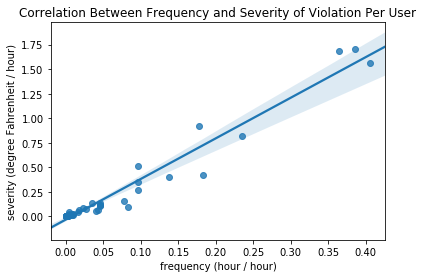

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

def plot_freq_sevr(datapoints):
    # Showing some stats
    X = [datapoint[0] for datapoint in datapoints]
    Y = [datapoint[1] for datapoint in datapoints]
    
    results = sm.OLS(Y, X).fit()
    
    print(results.summary())
    
    df = pd.DataFrame({'freq':X, 'sevr':Y})
    # Plotting the graph and the best-fit line
    sns.regplot('freq', 'sevr', df)
    
    plt.title('Correlation Between Frequency and Severity of Violation Per User')
    plt.xlabel('frequency (hour / hour)')
    plt.ylabel('severity (degree Fahrenheit / hour)')
    plt.show()
    
plot_freq_sevr(datapoints)

## Conclusion
By measuring frequency as number of hours divided by total number of hours recorded, and severity as the sum of the differences between required temperature and measured temperature all divided by total number of hours recorded, we factored out the number of hours recorded from the analysis.
However, we still find that severity (roughly how far below from required temperature actual temperature is) and frequency of violation is strongly correlated with the $r^2$ value of $0.961$.